In [1]:
#Librería auxiliar necesaria para hacer ciertos pasos de procesamiento de lenguaje natural
!python -m spacy download es_core_news_sm

!pip install bertopic
!pip install -U pysentimiento
!pip install transformers==4.36.0  #transformers==4.28.0        #Se instala una versión anterior de la libreria para el correcto funcionamiento de pysentimiento

!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 20.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using ca

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from wordcloud import WordCloud

import re
import string
import nltk
import spacy
from datasets import load_dataset

In [4]:
#Importación de librerias ocupadas para hacer modelacion de topicos
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

#Importación de librerias ocupadas para hacer analsis de sentimiento
from pysentimiento import create_analyzer

In [5]:
# Carga de Stop words en español
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('spanish'))
#Carga de tokenizador en español
nlp = spacy.load("es_core_news_sm")
translator = str.maketrans('', '',string.digits)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Carga de base de datos

In [6]:
all_articles = load_dataset("NickyNicky/Finance_cryptocurrency_Spanish_5.5k", trust_remote_code=True)
db = pd.DataFrame(all_articles['train'])[:5000]
db.info()

Generating train split:   0%|          | 0/5590 [00:00<?, ? examples/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   titular               5000 non-null   object
 1   noticia               5000 non-null   object
 2   Resumen               5000 non-null   object
 3   Pregunta 1            5000 non-null   object
 4   Respuesta 1           5000 non-null   object
 5   Pregunta 2            5000 non-null   object
 6   Respuesta 2           5000 non-null   object
 7   Pregunta 3            5000 non-null   object
 8   Respuesta 3           5000 non-null   object
 9   Pregunta 4            5000 non-null   object
 10  Respuesta 4           5000 non-null   object
 11  Pregunta 5            5000 non-null   object
 12  Respuesta 5           5000 non-null   object
 13  Pregunta 6            5000 non-null   object
 14  Respuesta 6           5000 non-null   object
 15  Toxico                5000 non-null   

## Procesamiento de lenguaje natural (NLP)

In [7]:
def preprocess_text(document):
    document = re.sub(r'\bSigue leyendo:.*', r"", document.replace("\n"," "))
    document = re.sub(r'\bFuente:.*', r"", document.replace("\n"," "))
    document = re.sub(r'\bRelacionado:.*', r"", document.replace("\n"," "))
    document = re.sub(r'\bAclaración:.*', r"", document.replace("\n"," "))
    document = re.sub(r'\bInforme:.*', r"", document.replace("\n"," "))

    document = re.sub(r'#(\w+)', '', document)
    document = re.sub(r'@(\w+)', '', document)
    document = re.sub(r'http?:\/\/.*[\r\n]*\/', '', document)
    document = re.sub(r'www?:\/\/.*[\r\n]* ', '', document)
    document = re.sub(r'(\w+).(\w+)?@(\w+).(\w+)', '', document)
    document = re.sub(r'(\w+)?@(\w+).(\w+)', '', document)

    # Remover todos los caracteres especiales y cambiar a minusculas
    document = re.sub(r'\W', ' ', document.lower())
    document = re.sub(r'\s+', ' ', document.translate(translator), flags=re.I)
    return re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

def tokenizador(texto):
  document = nlp(texto)
  tokens =  ' '.join([token.lemma_ for token in document if token.text not in en_stop and len(token.text)>3])
  return tokens

### Preprocesamiento

**Limpieza**

In [8]:
raw_text = []
for texto in db.titular.values:
    raw_text.append(preprocess_text(texto))

**Tokenización**

In [9]:
token_text = []
for text in raw_text:
  token_text.append(tokenizador(text))

(-0.5, 899.5, 399.5, -0.5)

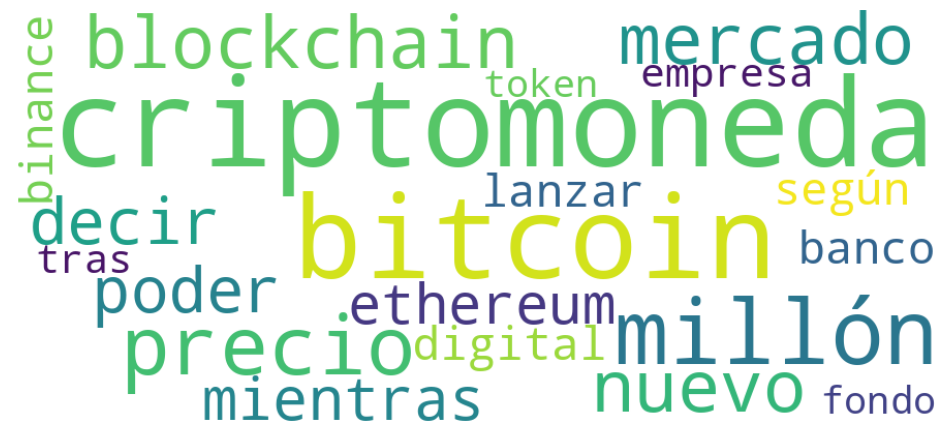

In [10]:
plt.figure(figsize=(12, 8))
nube=WordCloud(collocations =False,width=900, height=400,
    max_words=20,background_color="white",stopwords=en_stop).generate(" ".join(token_text))
plt.imshow(nube,interpolation='bilinear')
plt.axis("off")

In [11]:
print("Título: "+db.titular.values[0])
print("Preprocesado: "+raw_text[0])
print("Tokenizado: "+tokenizador(raw_text[0]))

Título: Según un informe, Indonesia lanzará un exchange de criptomonedas nacional en 2023
Preprocesado: según un informe indonesia lanzará un exchange de criptomonedas nacional en 
Tokenizado: según informe indonesio lanzar exchange criptomoneda nacional


### **Modelación de tópicos**

La modelación de tópicos es una estrategia que permite la extracción de temáticas inherentes en los documentos de texto.

Otra metodología para la modelación de tópicos es BERTopic, una metodología de 4 pasos que utiliza representaciones vectoriales de los documentos para crear los tópicos. De manera que, el primer paso de BERTopic es transformar los textos que son datos no estructurados en representaciones vectoriales. Este proceso se realiza con el esquema de Sentence-BERT(denotado como SBERT) que permite convertir sentencias y párrafos a vectores densos por medio de modelos preentrados. Las representaciones obtenidas por SBERT se encuentran en alta dimensión, lo cual trae consigo problemas por la maldición de la dimensionalidad, por lo que es recomendable reducir la dimensión de los embeddings.

Entre las técnicas de reducción de dimensión se encuentra el análisis de componentes principales, así como técnicas de manifold learning. En BERTopic se usa Uniform Manifold Approximation and Projection (UMAP por sus siglas en inglés), que es un método de reducción de dimensión que se ha mostrado capaz de capturar estructuras locales y globales del espacio original en un espacio de baja dimensión basado teóricamente en conceptos matemáticos como análisis de datos topológico y teoría de variedades que definen el curso de acción del algoritmo.

Una vez obtenidos los vectores (en alta o baja dimensión), el siguiente paso en BERTopic consiste en identificar textos similares por medio de una técnica de agrupación. El método de Hierarchical Density-Based Spatial Clustering (HDBSCAN por sus siglas en inglés) es el algoritmo predeterminado, el cual es un algoritmo de agrupamiento jerárquico basado en la estabilidad de los grupos.

Por último, BERTopic realiza la representación de los tópicos analizando los documentos de cada grupo, de manera que a cada grupo se le asigna un tema mediante la generalización de Term frequency - inverse document frequency(TF-IDF) denotado como c-TF-IDF la cual modela la importancia de las palabras por tópicos.



In [12]:
textos = db.titular.values
datos = token_text

In [13]:
model_1 = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
model_1.max_seq_length = 512
embeddings = model_1.encode(textos)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [14]:
umap_model = UMAP(n_neighbors=100, n_components=5, min_dist=0.0, metric='cosine', random_state=20)
hdbscan_model = HDBSCAN(min_cluster_size=100, metric='euclidean', cluster_selection_method='leaf', prediction_data=False)
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

topic_model = BERTopic(umap_model=umap_model,hdbscan_model=hdbscan_model, ctfidf_model=ctfidf_model,# n_gram_range=(1,2),
                       nr_topics=4,top_n_words=20)
topics, probs = topic_model.fit_transform(datos, embeddings = embeddings)
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2598,-1_milln_criptomoneda_binance_digital,"[milln, criptomoneda, binance, digital, banco,...",[proyecto prohibir activo digital medio pago s...
1,0,1936,0_bitcoin_precio_ethereum_blockchain,"[bitcoin, precio, ethereum, blockchain, mientr...",[precio enfrentar caída semana bitcoin evitar ...
2,1,273,1_argentina_argentino_espaa_brasil,"[argentina, argentino, espaa, brasil, brasileo...",[generación nuevo generación mundo crypto impu...
3,2,193,2_colapso_bahama_alameda_blockfi,"[colapso, bahama, alameda, blockfi, quiebra, i...",[blockfi declarar quiebra esperar mencionar co...


In [15]:
new_topics = topic_model.reduce_outliers(datos, topics, strategy="c-tf-idf")
topic_model.update_topics(datos, topics=new_topics)
vectorizer_model = TfidfVectorizer(min_df=0.3,stop_words=list(en_stop))
topic_model.update_topics(datos, vectorizer_model=vectorizer_model)
topic_model.get_topic_info()

2024-06-18 17:02:15,436 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


,Topic,Count,Name,Representation,Representative_Docs
0,-1,40,-1____,"[, , , , , , , , , ]",[proyecto prohibir activo digital medio pago s...
1,0,3401,0_bitcoin_precio_criptomoneda_blockchain,"[bitcoin, precio, criptomoneda, blockchain, mi...",[precio enfrentar caída semana bitcoin evitar ...
2,1,774,1_criptomoneda_banco_pago_argentino,"[criptomoneda, banco, pago, argentino, digital...",[generación nuevo generación mundo crypto impu...
3,2,785,2_milln_criptomoneda_bankman_fried,"[milln, criptomoneda, bankman, fried, binance,...",[blockfi declarar quiebra esperar mencionar co...


In [16]:
Topics = np.array(topic_model.topics_)

In [17]:
topic_model.visualize_barchart()

In [18]:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2,
                          min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(datos, reduced_embeddings=reduced_embeddings,
                                hide_document_hover=True, hide_annotations=True)

In [19]:
reduced_embeddings = UMAP(n_neighbors=100, n_components=2,
                          min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(datos, reduced_embeddings=reduced_embeddings,
                                hide_document_hover=True, hide_annotations=True)

**Tópico 1**

(-0.5, 899.5, 399.5, -0.5)

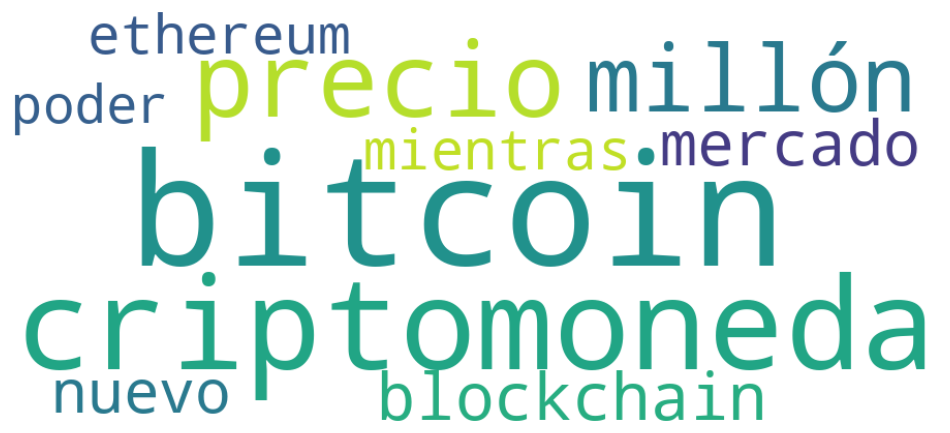

In [20]:
plt.figure(figsize=(12, 8))
nube=WordCloud(collocations =False,width=900, height=400,
    max_words=10,background_color="white",stopwords=en_stop).generate(" ".join(np.array(token_text)[Topics==0]))
plt.imshow(nube,interpolation='bilinear')
plt.axis("off")

**Tópico 2**

(-0.5, 899.5, 399.5, -0.5)

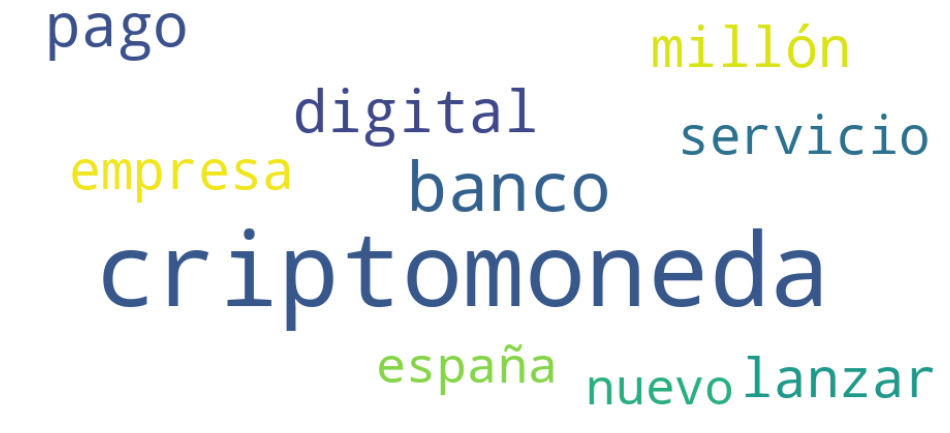

In [21]:
plt.figure(figsize=(12, 8))
nube=WordCloud(collocations =False,width=900, height=400,
    max_words=10,background_color="white",stopwords=en_stop).generate(" ".join(np.array(token_text)[Topics==1]))
plt.imshow(nube,interpolation='bilinear')
plt.axis("off")

**Tópico 3**

(-0.5, 899.5, 399.5, -0.5)

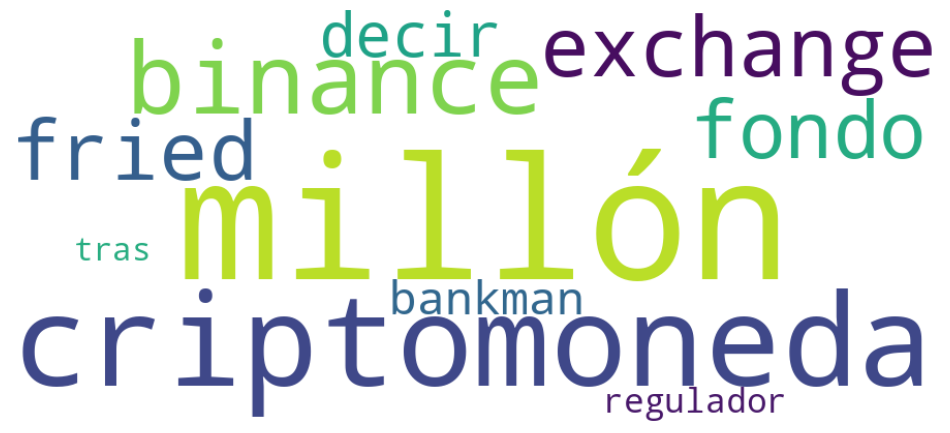

In [22]:
plt.figure(figsize=(12, 8))
nube=WordCloud(collocations =False,width=900, height=400,
    max_words=10,background_color="white",stopwords=en_stop).generate(" ".join(np.array(token_text)[Topics==2]))
plt.imshow(nube,interpolation='bilinear')
plt.axis("off")

### **Análisis de sentimiento**

El análisis de sentimiento (sentiment analysis, SA por sus siglas en inglés) permite estimar la polaridad de un texto lo cual permite conocer la opinión sobre diversos temas presentes en la sociedad como problemáticas, eventos o personas, de manera que se puede transformar las emociones en información importante para estudiar ciertos fenómenos.

Pysentimiento es una herramienta para realizar análisis de sentimiento y otras tareas para diversos idiomas, incluido el español. Para la tarea del análisis de sentimiento, el modelo se entrenó en el conjunto de datos de Twitter de \textit{TASS 2020 Task 1}, el cual está separado según diferentes dialectos del español, sin embargo, para este modelo se fusionaron todos los datos en un solo conjunto de datos, con las respectivas divisiones de entrenamiento, desarrollo y prueba.

In [23]:
#Llamamos la funcion para realizar el analisis de sentimiento
analyzer = create_analyzer(task="sentiment", lang="es")

config.json:   0%|          | 0.00/925 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/435M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

In [24]:
def obtener_polaridad(textos):
  #Aplicamos analisis de sentimiento en los tweets
  sent_head = analyzer.predict(textos)
  #Guardamos la probabilidad y categoria de la categoria mas alta
  prob_sent = np.max(pd.DataFrame([sent.probas for sent in sent_head]),axis=1)
  cat_sent = [sent.output for sent in sent_head]
  return pd.DataFrame({'Sentimiento':cat_sent,'Probabilidad':prob_sent})

In [25]:
#Calcular el sentimiento de los tweet de la base de datos
Sent = obtener_polaridad(textos)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

<Axes: xlabel='Sentimiento'>

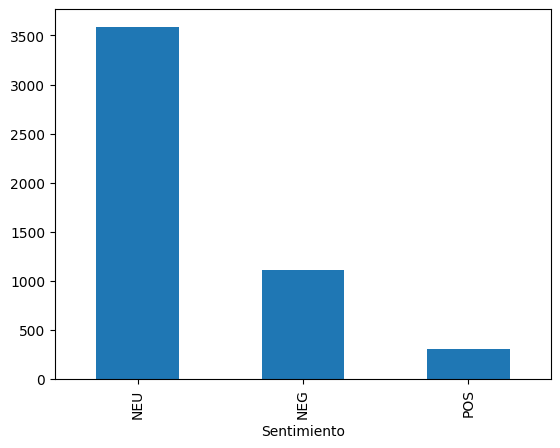

In [26]:
Sent.Sentimiento.value_counts().plot(kind='bar')

**Títulos con un sentimiento positivo**

In [27]:
for txt in textos[Sent.Sentimiento=='POS']:
  print(txt)
  print('\n')

“Latinoamérica es sin dudas uno de los lugares donde blockchain y crypto tienen mayor impacto”, Martín Gonzalez, CEO de BAG


El token LUNC de Terra es el gran ganador de la jornada con un alza de hasta ocho puntos porcentuales


Se registró exitosamente en el Banco de España una nueva plataforma para operar con criptomonedas


Myco, una plataforma audiovisual conectada a la Web3, estrena el segundo episodio de la serie The Blockchain Life


Drama de crimen on-chain de criptomonedas hace que por fin ganen los buenos


Axelar lanza un programa de ecosistema de startups de USD 60 millones


La comunidad Web3 comparte consejos para un proyecto GameFi exitoso


Aztec Network obtiene USD 100 millones en una ronda de financiación liderada por a16z


"Big Time" y otros juegos de la Web 3.0 se llevan el oro en la primera edición de los premios GAM3


Los NFT para toda la familia llevan a la próxima generación de jóvenes a Web3


El token de la plataforma Telegram es el gran ganador de la jorna

**Títulos con un sentimiento negativo**

(-0.5, 899.5, 399.5, -0.5)

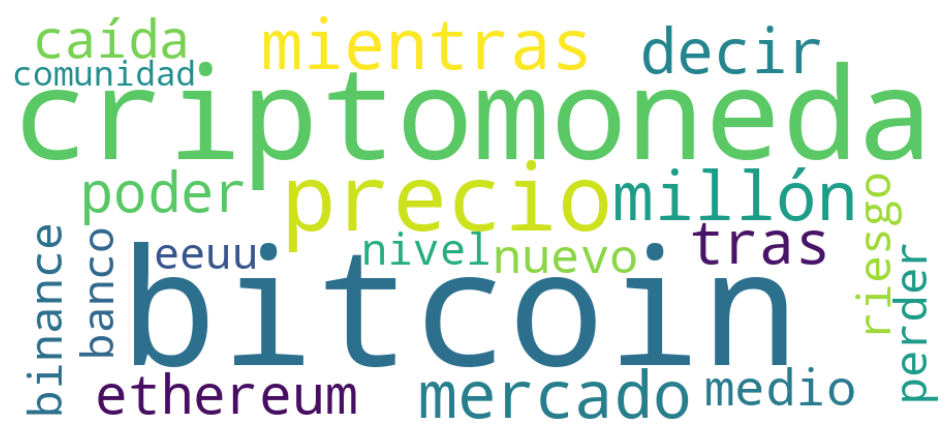

In [29]:
plt.figure(figsize=(12, 8))
nube=WordCloud(collocations =False,width=900, height=400,
    max_words=20,background_color="white",stopwords=en_stop).generate(" ".join(np.array(token_text)[Sent.Sentimiento=='NEG']))
plt.imshow(nube,interpolation='bilinear')
plt.axis("off")